# Part 2: Hardware Demo
## Outline
1. RPC server and client  
2. Signal generation and oscilloscope measurement  
    2.1 Pulse generation  
    2.2 Gate generation  
    2.3 Circuit generation  
3. Loopback test  
4. Readout emulator and GMM fitting  
5. Fast reset  

In [85]:
import qubic.toolchain as tc
import qubic.rpc_client as rc
import qubitconfig.qchip as qc
from distproc.hwconfig import FPGAConfig, load_channel_configs
import chipcalibration.config as cfg
import numpy as np
import matplotlib.pyplot as plt
import qubic.run
import qubic.state_disc as sd
from chipcalibration import vna as vn
import qubic.job_manager as jm

## 2. Signal generation and oscilloscope measurement
### 2.1 Pulse generation
### Load configs and define circuit
Using the chipcalibration repository, load all three configs:  
a. FPGA config: this has timing information for the scheduler  
b. Channel configs: firmware channel mapping + configuration, see [Understanding Channel Configuration](https://gitlab.com/LBL-QubiC/software/-/wikis/Understanding-Channel-Configuration) for details  
c. QChip object: contains calibrated gates + readout  

In [39]:
fpga_config = FPGAConfig(**{'fpga_clk_period': 2.e-9, 'alu_instr_clks': 5, 
                            'jump_cond_clks': 5, 'jump_fproc_clks': 5, 
                            'pulse_regwrite_clks': 3, 'pulse_load_clks': 4})
channel_configs = load_channel_configs('channel_config.json')
qchip = qc.QChip('qubitcfg.json')

Define a circuit at the pulse-level. For details on the QubiC circuit format and supported operations, see [compiler.py](https://gitlab.com/LBL-QubiC/distributed_processor/-/blob/master/python/distproc/compiler.py).

In [69]:
circuit_1 = [
    
    # play a pi/2 pulse on Q3
    {'name': 'pulse', 'phase': 0, 'freq': 2.7e9, 'amp': 0.99, 'twidth': 2.4e-08,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q3.qdrv'},
    
    # play a pi pulse on Q6
    {'name': 'pulse', 'phase': 0, 'freq': 700e6, 'amp': 0.50, 'twidth': 4.8e-08,
    'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
    'dest': 'Q6.qdrv'}

]

### Compile and assemble

Compile the program. The output of the compile stage is a distributed processor assembly program, which consists of initialization / termination statements, as well as a list of scheduled pulses for each core.

In [70]:
compiled_prog = tc.run_compile_stage(circuit_1, fpga_config, qchip)

Run the assembler to convert the above program into machine code that we can load onto the FPGA.

In [71]:
raw_asm = tc.run_assemble_stage(compiled_prog, channel_configs)

### Connect to Server and Run Circuit

Now that we've defined our circuit and compiled it to machine code, we can submit it to the ZCU216 and run it.

Instantiate the runner client.

In [16]:
runner = qubic.run.CircuitRunner(commit='f24f1615')
#runner = rc.CircuitRunnerClient(ip='localhost', port=9096)

mts: 0


Submit the circuit to the server, and collect 1000 shots.

In [72]:
s11 = runner.run_circuit_batch([raw_asm], 1000, delay_per_shot=0)

100%|██████████| 1/1 [00:00<00:00,  6.83it/s]


Observe the pulses on the oscilloscope or through the acq buffer.

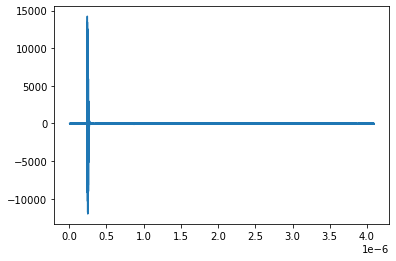

In [80]:
acq_data = runner.load_and_run_acq(raw_asm, n_total_shots=1, acq_chans=['0','1'], trig_delay=0e-9)
time_step=0.5e-9
plt.plot(np.arange(0,acq_data['1'].shape[1]*time_step,time_step)[10:],np.average(acq_data['1'], axis=0)[10:])

### 2.2 Gate generation
Define a circuit with calibrated gates / parameters.

In [134]:
circuit_2 = [
    
    # play two consecutive pi/2 pulses on Q3
    {'name': 'X90', 'qubit': 'Q3'},
    {'name': 'X90', 'qubit': 'Q3'},
    
    # schedule barrier
    {'name': 'barrier', 'qubit': ['Q3','Q6']},
    
    # play two pi/2 pulses on Q3 and Q6 simultaneously
    {'name': 'X90', 'qubit': 'Q3'},
    {'name': 'X90', 'qubit': 'Q6'},   

    # schedule barrier
    {'name': 'barrier', 'qubit': ['Q3','Q6']},
    
    # play a CNOT gate on Q3 and Q6
    {'name': 'CNOT', 'qubit': ['Q3','Q6']}
    
]

In [144]:
compiled_prog = tc.run_compile_stage(circuit_2, fpga_config, qchip)
raw_asm = tc.run_assemble_stage(compiled_prog, channel_configs)
s11 = runner.run_circuit_batch([raw_asm], 1000, delay_per_shot=0)

100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


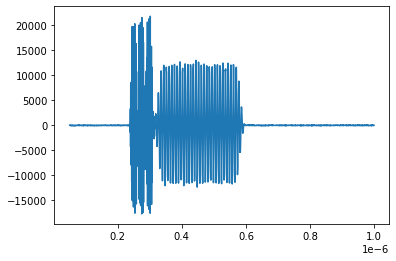

In [141]:
acq_data = runner.load_and_run_acq(raw_asm, n_total_shots=1, acq_chans=['0','1'], trig_delay=0e-9)
time_step=0.5e-9
plt.plot(np.arange(0,acq_data['1'].shape[1]*time_step,time_step)[100:2000],np.average(acq_data['1'], axis=0)[100:2000])

### 2.3 Circuit generation
Define a quantum circuit.

In [61]:
circuit_3 = [
    
    # allow qubit to decay to 0 state between shots
    {'name': 'delay', 't': 500.e-9}, 
    
    # set Q3 state to |1>
    {'name': 'X90', 'qubit': 'Q3'},
    {'name': 'X90', 'qubit': 'Q3'},
    
    # set Q6 to a state on the equator 
    {'name': 'X90', 'qubit': 'Q6'},
    
    # schedule barrier ensures that both readouts start after the pulses
    {'name': 'barrier', 'qubit': ['Q3', 'Q6']},
    
    # play readout gates for measurement
    {'name': 'read', 'qubit': 'Q3'},
    {'name': 'read', 'qubit': 'Q6'}

]

In [94]:
compiled_prog = tc.run_compile_stage(circuit_3, fpga_config, qchip)
raw_asm = tc.run_assemble_stage(compiled_prog, channel_configs)
s11 = runner.run_circuit_batch([raw_asm], 1000, delay_per_shot=0)

100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


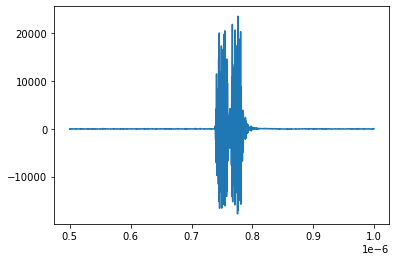

In [95]:
acq_data = runner.load_and_run_acq(raw_asm, n_total_shots=1, acq_chans=['0','1'], trig_delay=0e-9)
time_step=0.5e-9
plt.plot(np.arange(0,acq_data['1'].shape[1]*time_step,time_step)[1000:2000],np.average(acq_data['1'], axis=0)[1000:2000])

## 3. Loopback test
Sweep readout frequency like a VNA.

In [92]:
vna = vn.Vna(0.99, np.linspace(1.0e9, 7.0e9, 100), 10)
jobman = jm.JobManager(fpga_config, channel_configs, runner, qchip)
vna.run_and_report(jobman)

100%|██████████| 100/100 [00:01<00:00, 99.22it/s]


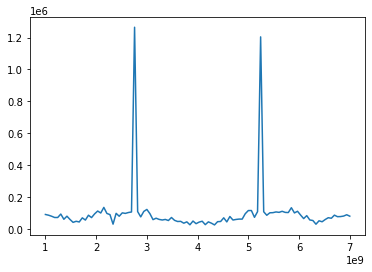

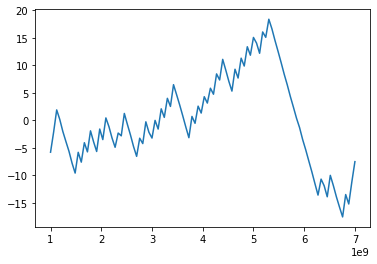

In [93]:
plt.plot(vna.freqs, vna.results['amp'])
plt.show()
plt.plot(vna.freqs, vna.results['phase'])
plt.show()

## 4. Readout emulator and GMM fitting
Create a qubit readout emulator.

In [285]:
fread=2.7568e9
circuit_4 = [
    {'name': 'read', 'qubit': 'Q3', 
     'modi':{(0, 'amp'): 0.99, (0, 'freq'): fread, (1, 'freq'): fread, (1, 'phase'): 0}}
]

In [286]:
compiled_prog = tc.run_compile_stage(circuit_4, fpga_config, qchip)
raw_asm = tc.run_assemble_stage(compiled_prog, channel_configs)
s11 = runner.run_circuit_batch([raw_asm], 2000, delay_per_shot=0)

100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


A dictionary of downconverted + integrated complex (IQ) values is returned for each loaded channel. Here, we're using Q3, so we get back data for channel '3'.

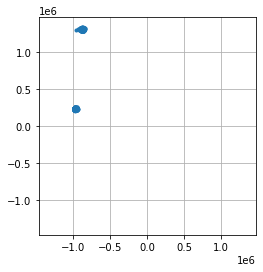

In [287]:
plt.figure()
ax1=plt.subplot(111)
ax1.set_aspect('equal')
plt.plot(s11['3'].real[0], s11['3'].imag[0], '.')
lim=max(1.1*max(max(abs(s11['3'].real[0])),max(abs(s11['3'].imag[0]))),0.1)
ax1.set_xlim([-lim,lim])
ax1.set_ylim([-lim,lim])
plt.grid()

Fit the two blobs with GMM

In [288]:
gmm_manager = sd.GMMManager(chanmap_or_chan_cfgs=channel_configs)
gmm_manager.fit(s11)
gmm_manager.gmm_dict['Q3'].gmmfit.means_

array([[-972542.264,  233243.415],
       [-880910.767, 1311333.576]])

In [289]:
angle = gmm_manager.get_threshold_angle('Q3')
circuit_5 = [
    {'name': 'read', 'qubit': 'Q3',
     'modi':{(0, 'amp'): 0.99, (0, 'freq'): fread, (1, 'freq'): fread, (1, 'phase'): np.pi/2 - angle}}
]

In [290]:
compiled_prog = tc.run_compile_stage(circuit_5, fpga_config, qchip)
raw_asm = tc.run_assemble_stage(compiled_prog, channel_configs)
s11 = runner.run_circuit_batch([raw_asm], 2000, delay_per_shot=0)

100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


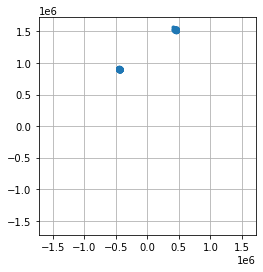

In [291]:
gmm_manager = sd.GMMManager(chanmap_or_chan_cfgs=channel_configs)
gmm_manager.fit(s11)
plt.figure()
ax1=plt.subplot(111)
ax1.set_aspect('equal')
plt.plot(s11['3'].real[0], s11['3'].imag[0], '.')
lim=max(1.1*max(max(abs(s11['3'].real[0])),max(abs(s11['3'].imag[0]))),0.1)
ax1.set_xlim([-lim,lim])
ax1.set_ylim([-lim,lim])
plt.grid()

## 5. Fast reset

In [293]:
cond_lhs=1 if gmm_manager.gmm_dict['Q3'].gmmfit.means_[0][0]>0 else 0
circuit_6 = [
    {'name': 'X90', 'qubit': 'Q3'},
    {'name': 'read', 'qubit': 'Q3', 
     'modi':{(0, 'amp'): 0.99, (0, 'freq'): fread, (1, 'freq'): fread, (1, 'phase'): np.pi/2 - angle}},
    {'name': 'branch_fproc', 'alu_cond': 'eq', 'cond_lhs': cond_lhs, 'func_id': 3, 'scope': 'Q3',
                'true': [{'name': 'delay', 't': 200.e-9, 'qubit': 'Q3'},
                             {'name': 'X90', 'qubit': 'Q3', 'modi':{(0, 'amp'): 0.99, (0, 'freq'): 900e6}}, 
                             {'name': 'X90', 'qubit': 'Q3', 'modi':{(0, 'amp'): 0.99, (0, 'freq'): 900e6}}], 
                'false': []},
]

In [306]:
compiled_prog = tc.run_compile_stage(circuit_6, fpga_config, qchip)
raw_asm = tc.run_assemble_stage(compiled_prog, channel_configs)
s11 = runner.run_circuit_batch([raw_asm], 1, delay_per_shot=0)

100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


In [307]:
print(s11)
gmm_manager.predict(s11)

{'3': array([[[388961.+1563633.j]]])}


{'Q3': array([[[1]]])}